## Notebook demonstrating how to use Monda to access So-Rad above-water radiometry data 

Monda (MONocle data analysis) is a suite of tools for retrieving, quality checking, plotting, and saving data from sensors developed during the MONOCLE project: https://pypi.org/project/monda/


The So-Rad (Solar-tracking Radiometry) platform is one of the sensor systems accessed via Monda. So-Rad conists of a downwelling irradiance sensor (Ed), a sky radiance sesnor (Lsky), and a water radiance sensor (Lt), which are automatically processed to derive remote-sensing reflectance (Rrs): https://www.monocle-h2020.eu/Sensors_and_platforms/Solar_tracking_radiometry_platform_en


So-Rad systems are available on request as service from NEODAAS (NERC Earth Observation Data Analysis and Artificial-Intelligence Service). The service includes remote installation support and data processing: https://www.neodaas.ac.uk/Services/Water_reflectance_sensor_observation_instruments

 This notebook is designed for end-users of So-Rad data. It demonstrates how to: 
- 1.   Retrieve pre-processed So-Rad Rrs and (ir)radiance spectra from PML Geoserver using WFS standard
- 2.   Apply a set of quality control filters
- 3.  Plot data illustrating quality control, data coverage, and reflectanace spectra.
- 4.  Save results

Steps 1 - 4 use a single day for demonstration purposes. At the end of the notebook is an example where data is extracted for multiple days (section 5).

In [47]:
# Core imports
import sys
import os
import numpy as np

# Note `qc' import does not work via monda (also issues in ADIAS).
# from monda.sorad import access, plots, qc  # This will be used for import once issue is fixed

# For spring 2024 changes, I have used a local import of qc, plots and access as a temporary work-around
sys.path.append('/users/rsg/tjor/Sorad_mondademos/MONDA/src/monda/sorad')  # for 2024 changes.
import qc 
import plots
import access

import datetime
import logging
import pandas as pd
import argparse
from math import ceil


## 1.  Retrieve pre-processed So-Rad Rrs and (ir)radiance spectra from PML Geoserver using WFS standard

#### Monda uses the following user-defined fields to retrieve So-Rad data

- platform_id:  the serial number of a So-Rad platform
- start_time:   date/time to start collecting data from
- end_time:     date/time to start collecting data from
- bbox:         bounding box corner coordinates (lat,lon,lat,lon)
- target:        destination folder for plots/data
- rrsalgorithm:   choice of fingerprint (fp) or 3c Rrs processing algorithm. 3c used as default


#### Data from multiple So-Rad systems available on the WFS Geoserver. A data dashboard, which summarises aquistion dates and locations is provided here: https://rsg.pml.ac.uk/dashboards/d/JUzLKd9nz/monocle-so-rad?orgId=1




In [48]:
# Sets So-Rad platform ID. As of May 2024, data from the following systems are available: PML_SR001, PML_SR002, PML_SR003, PML_SR004, PML_SR005, PML_SR007, PML_SR009, PML_SR0012.
platform_id = 'PML_SR001' 

# PML_SR001 is typically deployed on PML's research vessel Quest between Spring-Autumn each year. Data is available since 2021.
# The deployment dates for PML_SR001 data are:
    # 2024:  10/04/2024 -
    # 2023:  12/06/2023 - 10/10/2023
    # 2022:  23/04/2022 - 08/16/2022
    # 2021:  25/04/2021 - 13/04/2021  

In [49]:
# Set start and end datetimes for data query -  a single date is used for demonstration purposes
start_time =   datetime.datetime.strptime('2023-10-10', '%Y-%m-%d')
end_time   =   datetime.datetime.strptime('2023-10-11', '%Y-%m-%d')


In [50]:
# Set choice of rrs processing algorithm. So-Rad data is processed using either the Fingerprint (FP) algorithm, Simis and Olsson 
# 2013, Remote Sensing of Environment, or 3C, Groetsch et al. 2017, Optics Express. 3C uses the paramterisation in
# Jordan et. al 2022. Remote Sensing. Each algorithm has its' own quality control chain. This notebook uses 3C as a default.

rrsalgorithm = '3c' # other option `fp' (fingerprint)
if rrsalgorithm == 'fp':
    layer = 'rsg:sorad_public_view_fp_full'
elif rrsalgorithm == '3c':
    layer = 'rsg:sorad_public_view_3c_full'
else:
    log.error(f"{rrsalgorithm} is not a valid choice and must be one of [fp, 3c]")
wl_output = np.arange(350, 900, 1)  # output range to interpolate (ir)radiance spectra. Note that Rrs is already interpolated to 1-nm over the available sensor range.


In [51]:
# Set other parameters needed to retrieve data
bbox = None # An optional bounding box is specified providing four space-separated coordinates (corner 1 lat lon corner 2 lat lon).
target = '../tests/your_data_folder' # folder to save data. If no folder is given, then data is saved in working directory 

In [52]:
# This function retrieves So-Rad Rrs data from that has already been processed using the 3c method
response = access.get_wfs(platform = platform_id,
                          timewindow = (start_time, end_time),
                          layer='rsg:sorad_public_view_3c_full',
                          bbox=None)

# The retreived fields (including metadata, input (ir)radiance spectra, output rr spectra, and optimzation parameters 
#from 3c are listed below:
print(response['result'][0].keys()) 

2024-05-07 16:03:28,988 | sorad-downloader | INFO | Pre-paging request: https://rsg.pml.ac.uk/geoserver/rsg/wfs?request=GetFeature&version=2.0.0&service=WFS&typeName=rsg:sorad_public_view_3c_full&count=1000&srsname=EPSG:4326&outputFormat=json&sortBy=time+A&CQL_FILTER=time%20between%202023-10-10T00%3A00%3A00%20AND%202023-10-11T00%3A00%3A00%20AND%20platform_id%3D%27PML_SR001%27&resultType=hits
2024-05-07 16:03:29,350 | sorad-downloader | INFO | 319 features matched
2024-05-07 16:03:31,088 | sorad-downloader | INFO | Page 0, starting at count 0: 319 features
dict_keys(['id', 'time', 'platform_id', 'sample_uuid', 'platform_uuid', 'gps_speed', 'rel_view_az', 'tilt_avg', 'tilt_std', 'license', 'c3_rmsd', 'c3_resid', 'c3_delta', 'c3_rho_s', 'c3_rho_dd', 'c3_rho_ds', 'c3_alpha', 'c3_beta', 'c3_updated', 'c3_wl_grid', 'c3_rrs', 'lt_wl', 'lt_spectrum', 'ls_wl', 'ls_spectrum', 'ed_wl', 'ed_spectrum', 'lon', 'lat'])


The retreived fields can be grouped as:

- (ir)radiance data: 'ed_spectrum', 'ed_wl', 'ls_spectrum', 'ls_wl', 'lt_spectrum', 'lt_wl'
ed is downwelling irradiance, ls is sky radiance, lt is total water (upwelling) radiance. There are wavelength vectors for each spectra

- reflectance data and 3c optimization output: 'c3_rrs', 'c3_wl_grid', 'c3_alpha', 'c3_beta', 'c3_delta', 'c3_resid', 'c3_rho_dd', 'c3_rho_ds', 'c3_rho_s', 'c3_rmsd', , 'c3_updated','c3_rrs'
rrs is c3_wlgrid

- Metadata: 'id', 'lat', 'license', 'lon', 'platform_id', 'platform_uuid', 'rel_view_az', 'sample_uuid', 'tilt_avg', 'tilt_std', 'time'.




In [53]:
# This function is used to convert output fields within response into np arrays

def unpack_response(response, rrsalgorithm, wl_out):
    """
    Unpack the WFS response
    """
    #log.info(response['result'][0].keys())   # uncomment to show all available fields

    time          = [response['result'][i]['time'] for i in range(len(response['result']))]
    lat           = np.array([response['result'][i]['lat'] for i in range(len(response['result']))])
    lon           = np.array([response['result'][i]['lon'] for i in range(len(response['result']))])
    rel_view_az   = np.array([response['result'][i]['rel_view_az'] for i in range(len(response['result']))])
    sample_uuid   = np.array([response['result'][i]['sample_uuid'] for i in range(len(response['result']))])
    platform_id   = np.array([response['result'][i]['platform_id'] for i in range(len(response['result']))])
    platform_uuid = np.array([response['result'][i]['platform_uuid'] for i in range(len(response['result']))])
    gps_speed     = np.array([response['result'][i]['gps_speed'] for i in range(len(response['result']))])
    tilt_avg      = np.array([response['result'][i]['tilt_avg'] for i in range(len(response['result']))])
    tilt_std      = np.array([response['result'][i]['tilt_std'] for i in range(len(response['result']))])

    ed = access.get_l1spectra(response, 'ed_', wl_out) # # irradiance spectra in 2D matrix format: rows time index, columns wavelength
    ls = access.get_l1spectra(response, 'ls_', wl_out)
    lt = access.get_l1spectra(response, 'lt_', wl_out)


    if rrsalgorithm == '3c':
        rrswl = np.arange(response['result'][0]['c3_wl_grid'][0], response['result'][0]['c3_wl_grid'][1], response['result'][0]['c3_wl_grid'][2])  # reconstruct wavelength grid for Rrs
        rrs = np.array([response['result'][i]['c3_rrs'][:] for i in range(len(response['result']))]) # 2D matrix format: rows time index, columns wavelength

    elif rrsalgorithm == 'fp':
        rrswl  = np.arange(response['result'][0]['wl_grid'][0], response['result'][0]['wl_grid'][1]-1, response['result'][0]['wl_grid'][2])  # reconstruct wavelength grid for Rrs
        rrs_    = np.array([response['result'][i]['rrs'][:] for i in range(len(response['result']))])  # rrs spectra 2D matrix format: rows time index, columns wavelength
        offset = np.array([response['result'][i]['nir_offset'] for i in range(len(response['result']))])
        rrs = np.array([rrs_[i,:] - np.ones(len(rrswl))*offset[i] for i in range(len(rrs_))]) # spectral offset (applied as default definition of FP rrs)

    return rrswl, time, lat, lon, rel_view_az, ed, ls, lt, rrs, sample_uuid, platform_id, platform_uuid, gps_speed, tilt_avg, tilt_std



In [54]:
# extracts data in np.array formats.
rrswl, time, lat, lon, rel_view_az,\
       ed, ls, lt, rrs,\
       sample_uuids, platform_ids, platform_uuids,\
       gps_speeds, tilt_avgs, tilt_stds = unpack_response(response, rrsalgorithm, wl_output)


## 2. Apply a set of Quality Control filters
#### The quality control and plot functions within MONDA are designed to operate on daily data chunks. Here we provide a worked example for a single day of data. At the end of this notebook we provide code so that multiple days can be extracted, quality-controlled, and saved.

The quality control is applied sequentially in 4 levels:
- Step (0) QC filters based on relative aziumuth and tilt/tilt std
- Step (ii) Level 1 radiometric quality control filters (i.e. QC applied to radiance or irradiance spectra)
- Step (ii) Level 2 quality control filters specific to 3c optimization 
- Step (iii) Level 2 quality control filters that apply to reflectance spectrum.

The output to each quality control function is a binary mask (1 = QC pass, 0 == QC fail). There are multiple sub-flags for each step, which are grouped together following a logical OR gate.

Individual quallity control functions are documented here:
https://github.com/monocle-h2020/MONDA/blob/master/src/monda/sorad/qc.py

In [92]:
# Step (0) QC filters based on relative aziumuth and tilt/tilt std
q_az =  qc.rel_az_filter(rel_view_az, lower_azi_bound = 110, upper_azi_bound = 170)
q_tilt, q_tilt_std =  qc.tilt_filter(tilt_avgs, tilt_stds, upper_tilt_bound=5, upper_tilt_std_bound = np.sqrt(3))
q_0 =  qc.combined_filter(q_az , qc.combined_filter(q_tilt, q_tilt_std))

Tilt sensor was stuck on single value: do not apply tilt filter


In [103]:
# Step (i) radiometric quality control filters (i.e. QC applied to radiance or irradi spectra)
q_lt_ed = qc.qc_lt_ed_filter(ed, lt, time, wl_output, threshold = 0.050) # lt/Ed ratio (glint) filtering
q_ed =    qc.qc_ed_filter(ed, min_ed_threshold = 500) # filters on ed and ls anomalies
q_ls =    qc.qc_ls_filter(ls, wl_output, threshold = 1)
q_1 =     qc.combined_filter(qc.combined_filter(qc.combined_filter(q_lt_ed, q_ed), q_ls), q_0) # combined `radiometric' qc mask - inlcludes data passing step(0)

# This is an example of an individial qc mask
print(q_ed)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 1. 1. 1. 1. 1. 0. 0.]


In [104]:
# This is an example of an individial qc mask. Light levels were relatively low for above-water radiometry (it was an overcast day in October),
# so multiple measurements were below threshold irradadiance levels.
print(q_ed)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 1. 1. 1. 1. 1. 0. 0.]


In [106]:
# This is the q_1 mask (which combines all flags at step (0) and step (i) under an OR gate).
print(q_1)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.
 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0.
 1. 1. 1. 1. 1. 0. 0.]


In [107]:
# Step (ii): (3c) algorithmic qc filters specfic to 3C (rmsd or termination at rho bounds)
if rrsalgorithm == '3c':
    rmsd_3c =     np.array([response['result'][i]['c3_rmsd'] for i in range(len(response['result']))]) # rmsd values used in 3C residual filter
    rho_ds =      np.array([response['result'][i]['c3_rho_ds'] for i in range(len(response['result']))]) # rho factors
    rho_dd =      np.array([response['result'][i]['c3_rho_dd'] for i in range(len(response['result']))])
    rho_s =       np.array([response['result'][i]['c3_rho_s'] for i in range(len(response['result']))])
    q_rho =       qc.qc_3c_rho_filter(rho_ds, rho_dd, rho_s, upperbound = 0.1) # removes data where rho terminates at optimization bounds
    q_1_resid = qc.qc_3cresidual(q_1, rmsd_3c, tol = 1.5) # removes data where residual parameter is above threshold standard-deivation multiple
    q_2 =    qc.combined_filter(q_rho, q_1_resid)


In [108]:
# Step (iii): addtional qc metrics that apply to Rrs spectrum
q_ss =        qc.qc_SS_NIR_filter(rrswl, rrs, upperthreshold = 3, lowerthreshold = 0.5)  # similarity spectrum filter
q_maxrange =  qc.qc_rrs_maxrange(rrs, upperthreshold = 0.1, lowerthreshold = 0.00)    # filters on max and min rrs
q_min =       qc.qc_rrs_min(rrs, rrswl)

# Optional filters
# q_coastal = qc_coastalwater_rrsfilter(rrs, wl) #  filter based on expected shape of rrs - example from Warren 2019 used. users can input their own spectra here (will depend on water type)
# q_var = qc_radiometric_variability(ed, lt, ls, time, wl, windowlength = 60, var_threshold =1.1, var_metric = 'zscore_max')

if rrsalgorithm == '3c':
    q_3 = qc.combined_filter(q_2, qc.combined_filter(q_min, (qc.combined_filter(q_ss, q_maxrange)))) # recommended rrs qc mask for 3C method (combines step (i), (ii) and (iii) QC)
elif rrsalgorithm == 'fp':
    q_3 = qc.combined_filter(q_1, qc.combined_filter(q_min, (qc.combined_filter(q_ss, q_maxrange)))) # recommended rrs qc mask for FP method (combines step (i) and (iii) QC)


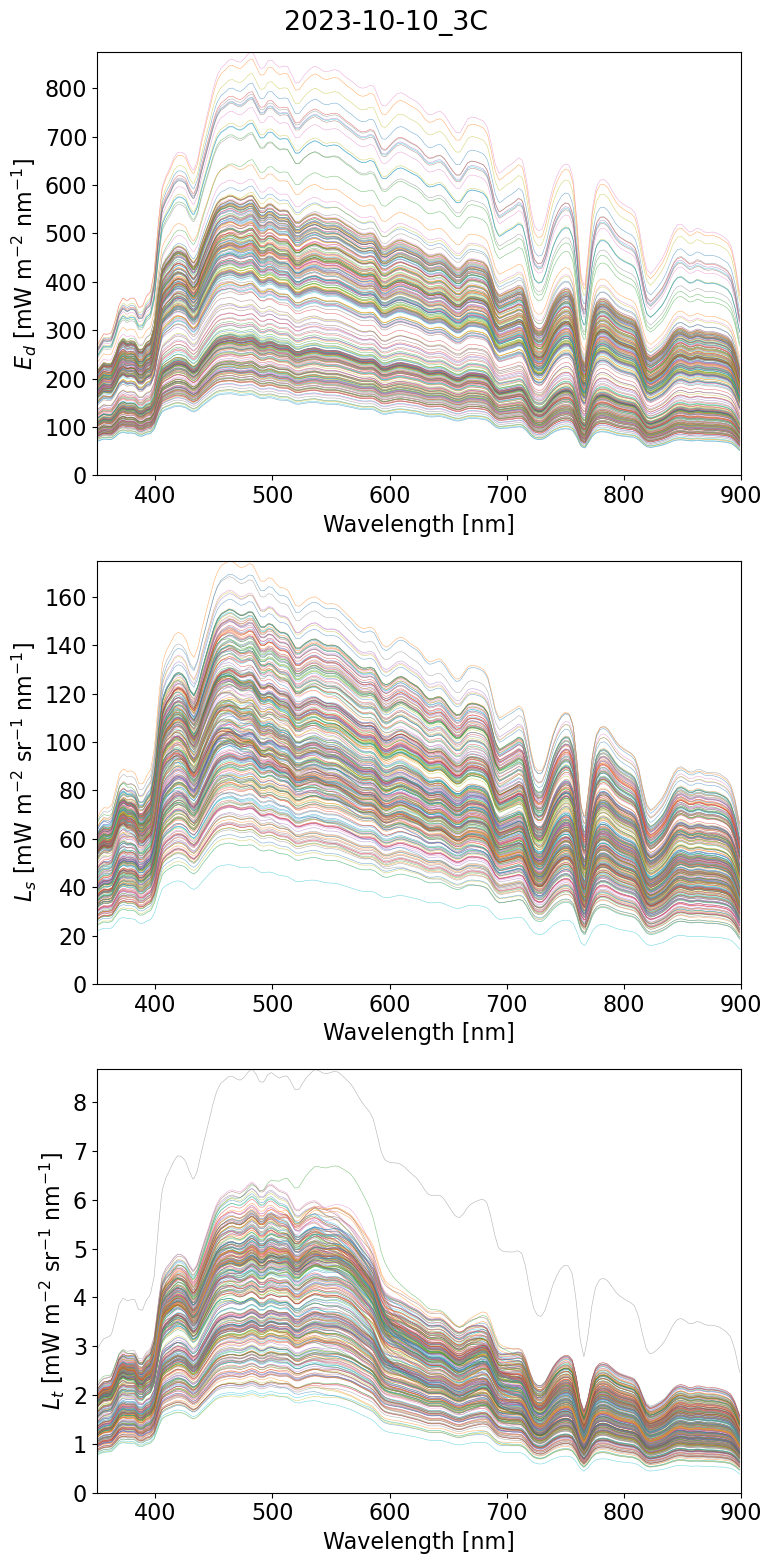

In [109]:
# Output irradiance spectra
file_id = f"{start_time.strftime('%Y-%m-%d')}_{rrsalgorithm.upper()}"   
plots.plot_ed_ls_lt(ed, ls, lt, time, wl_output, file_id, target)


## 3. Plot data 

<Figure size 640x480 with 0 Axes>

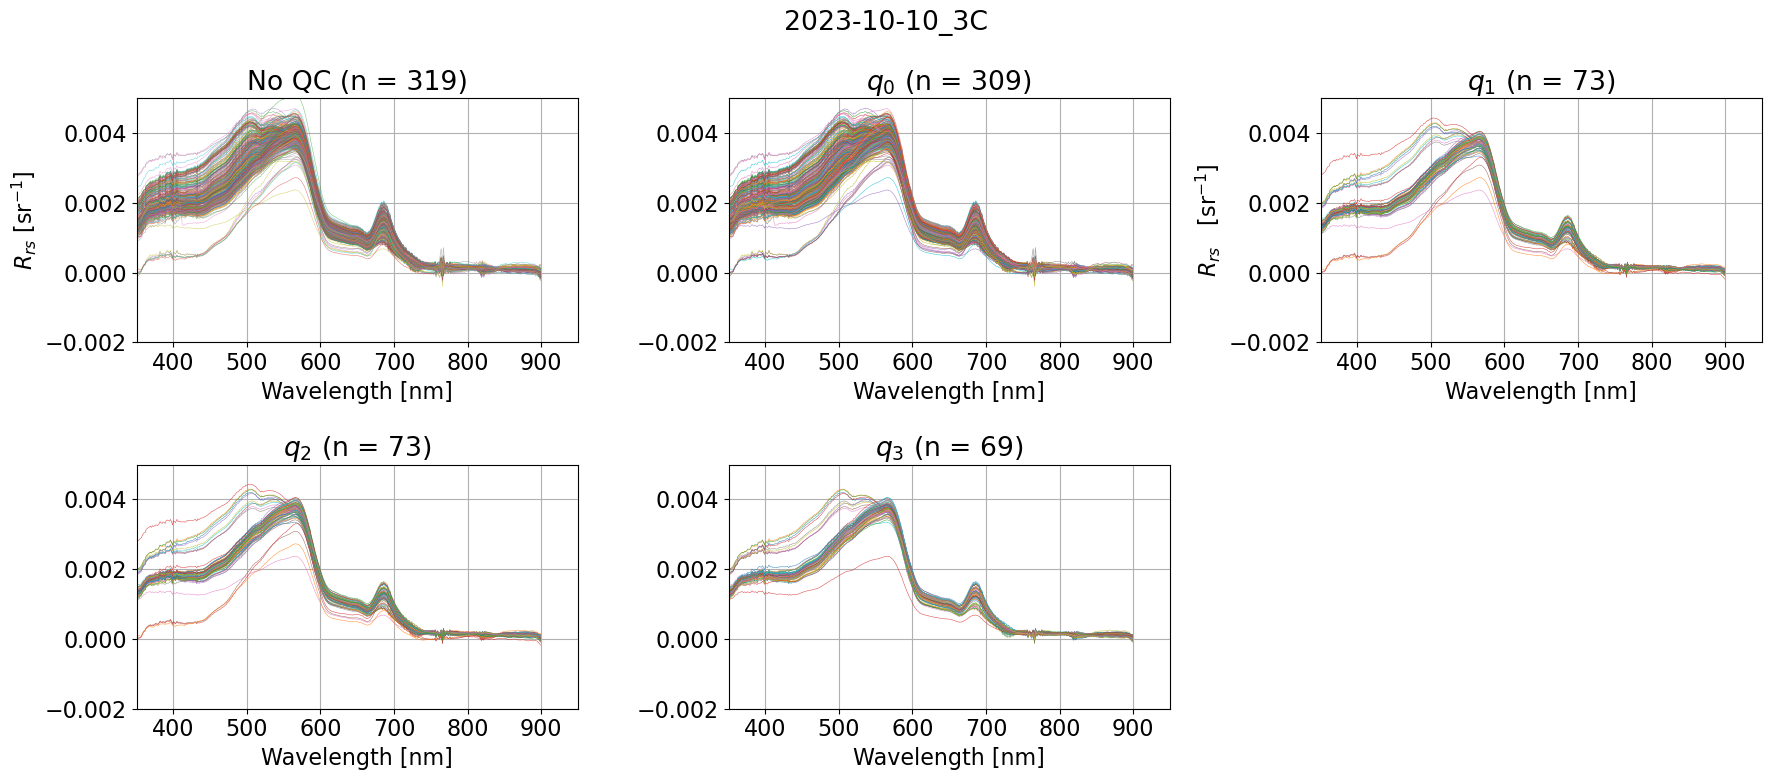

In [110]:
if rrsalgorithm == '3c':
    # This figure illustrates seqentially the different QC masks
    plots.plot_rrs_qc_3c(rrs, time, rrswl, q_0, q_1, q_2, q_3, file_id, target)



2024-05-07 17:36:08,620 | matplotlib.legend | WARNING | No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


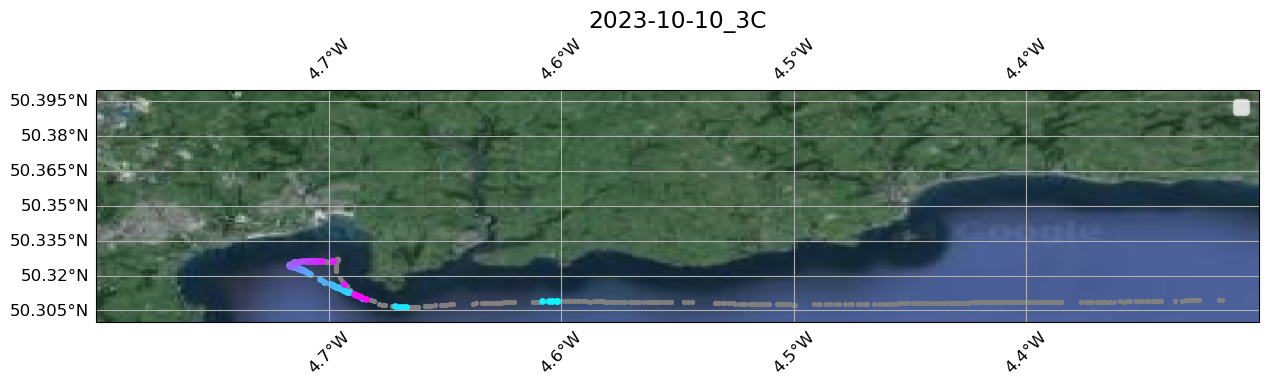

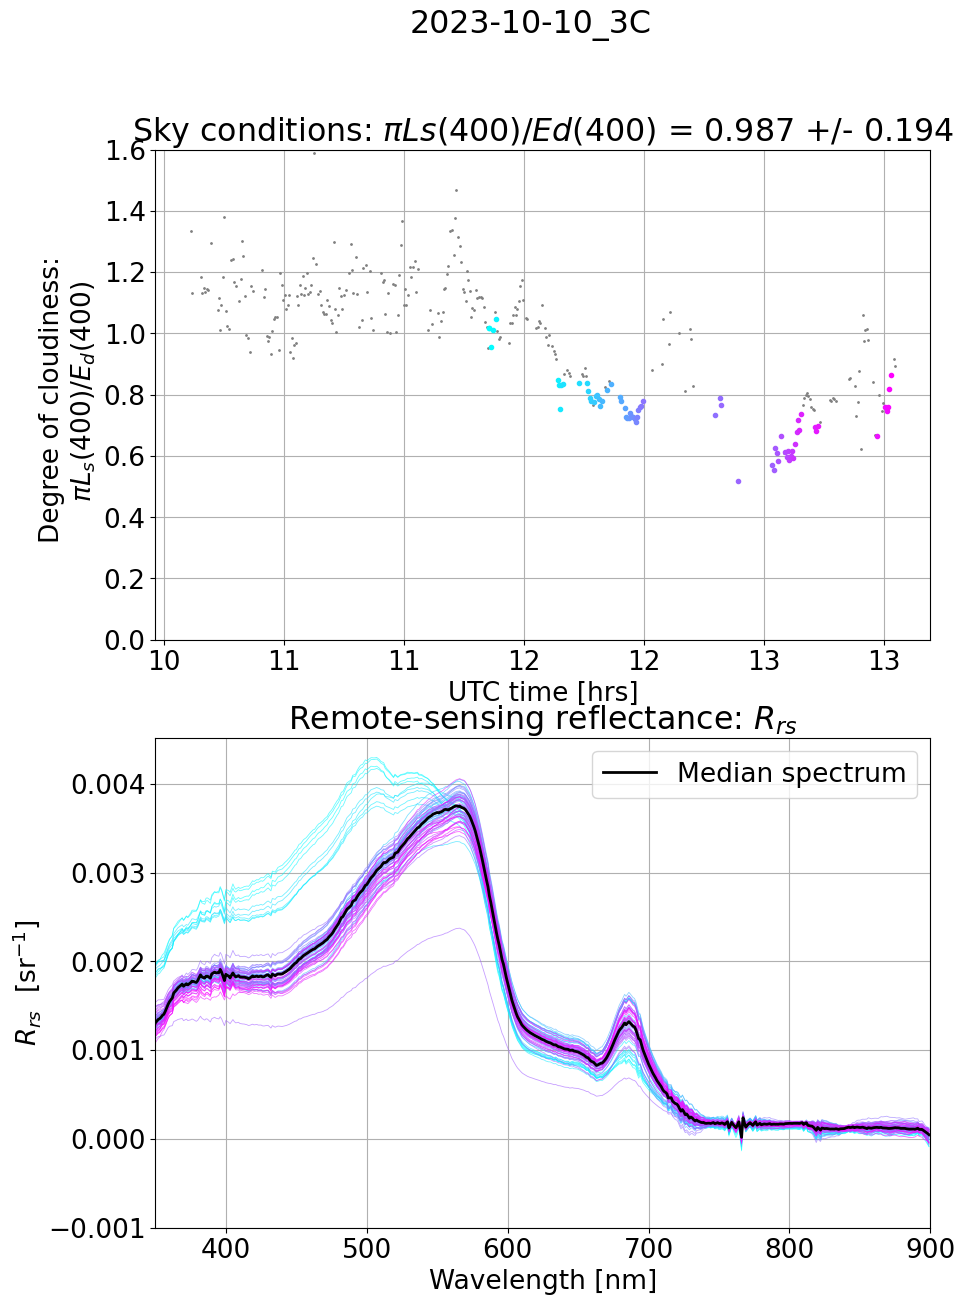

In [111]:
# Theses figures illustrate coverage maps and reflectance results for data that has been quality-controlled. The upper panel in results figure shows
# shows a time series for a cloudiness proxy (values ~ 1 are overcast, and values ~ 0.3 are clear skies). See Simis and Olson 2013 for more details.
if rrsalgorithm == '3c':
    plots.plot_coveragemap(lat, lon, q_3, file_id, target, map_resolution = 11)
    plots.plot_results(ed, ls, wl_output, rrs, rrswl, time, q_3, file_id, target)

In [112]:
# these are fingerprint-variants of the plot functions 
if rrsalgorithm == 'fp':
    plots.plot_rrs_qc_fp(rrs, time, rrswl, q_1, q_3, file_id, target)
    plots.plot_coveragemap(lat, lon, q_3, file_id, target, map_resolution = 11)
    plots.plot_results(ed, ls, wl_output, rrs, rrswl, time, q_3, file_id, target)


## 4. Save results

In [119]:
# save meta data in csv format
d = pd.DataFrame()   # store core metadata and qc flags in a data frame for easy output formatting
d['sample_uuid'] = sample_uuids
d['platform_id'] = platform_ids
d['platform_uuid'] = platform_uuids
d['timestamp'] = time
d['lat'] = lat
d['lon'] = lon
d['gps_speed'] = gps_speeds
d['tilt_avg'] = tilt_avgs
d['tilt_std'] = tilt_stds
d['rel_view_az '] = rel_view_az
d['q_0'] = q_0     # Mask after step (0) QC
d['q_1'] = q_1     # Mask after step (i) QC

if rrsalgorithm == 'fp':
    d['q_3'] = q_3 # Mask after step (iii) QC: currently recommended for FP rrs data analysis

elif rrsalgorithm == '3c':
    d['q_2'] = q_2   # Mask after step (ii) QC (only applies to 3C)
    d['q_3'] = q_3  # Mask after step (iii) QC: currently recommended for 3C  rrs data analysis

d_filename = os.path.join(target, file_id + '_metadata.csv')
d.to_csv(d_filename)

In [120]:
# save rrs, ed, lt, ls in csv format. The rows are timestamps (matching number of rows in each meta data file) and the columns are the timestamps
r_filename = os.path.join(target, file_id + '_Rrs.csv')
np.savetxt(r_filename, rrs, delimiter=',',  header = ",".join([str(w) for w in rrswl]), fmt='%.8f')

header = ",".join([str(w) for w in wl_output])
ls_filename = os.path.join(target, file_id + '_Ls.csv')
lt_filename = os.path.join(target, file_id + '_Lt.csv')
ed_filename = os.path.join(target, file_id + '_Ed.csv')
np.savetxt(ls_filename, ls, delimiter=',', header = header, fmt='%.8f')
np.savetxt(lt_filename, lt, delimiter=',', header = header, fmt='%.8f')
np.savetxt(ed_filename, ed, delimiter=',', header = header, fmt='%.8f')

In [ ]:
This section shows how to ouput multiple days at once.

This section of notebook code is taken from, and this script can be also be used directly by end-users: https://github.com/monocle-h2020/MONDA/tree/master/src/monda/tests